# Transfer Learning with TensorFlow Part 3: Scaling up (🍔👁 Food Vision mini)

We've seen the power of transfer learning feature extraction and fine-tuning, now it's time to scale up to all of the classes in Food101 (101 total classes of food).

Our goal is to beat the original Food101 paper with 10% of the training (leveraging the power of deep learning).

Original Food101 paper: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

Our baseline to beat is 50.76% accuracy across 101 classes.

## Creating helper functions

In previous notebooks, we've created a series of helper functions to do different tasks, let's download them.

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2025-01-10 10:34:49--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-01-10 10:34:49 (82.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## 101 Food Classes: working with less data

Our goal is to beat the original Food101 paper with 10% of the training data, so let's download it.

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2025-01-10 10:34:57--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.130.207, 74.125.68.207, 64.233.170.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.130.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  21.9MB/s    in 78s     

2025-01-10 10:36:16 (20.0 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
unzip_data("101_food_classes_10_percent.zip")

In [ ]:
!rm "101_food_classes_10_percent.zip"

In [ ]:
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [ ]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/omelette'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/seaweed_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/paella'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cheesecake'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/shrimp_and_grits'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/french_toast'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/macaroni_and_cheese'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/chocolate_mousse'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/beignets'.
There are 0 directories and 250 

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                             label_mode="categorical",
                                                             image_size=IMG_SIZE,
                                                             shuffle=False) # Don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes

Here are the steps we're going to take:

* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficientNetB0 backboned-model (we'll create our own output layer)
Compile our model
* Feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% of the test data, to save epoch time)

In [ ]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint.weights.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [ ]:
# Create data augmentation layer to incorporate it right into the model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Create data augmentation stage with horizontal flipping, rotations, zooms, etc
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2)
    # layers.Rescaling(1./255) # Keep for models like ResNet50V2 but EfficientNet's having resclaing built-in
], name="data_augmentation")

In [ ]:
# Setup the base model amd freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs) # augment images (only happens during training phase)
x = base_model(x, training=False) # put the base model in inference mode so weights which need to stay frozen, stay froze
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
# Get a summary of model we've created
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, None, None, 1280)    │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_avg_pool_layer                │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 101)                 │         129,381 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)),
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 59s 191ms/step - accuracy: 0.1290 - loss: 4.0578 - val_accuracy: 0.3639 - val_loss: 2.7446
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 74s 173ms/step - accuracy: 0.4099 - loss: 2.5970 - val_accuracy: 0.4526 - val_loss: 2.1993
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 41s 171ms/step - accuracy: 0.4756 - loss: 2.2042 - val_accuracy: 0.5148 - val_loss: 1.9465
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 42s 175ms/step - accuracy: 0.5251 - loss: 1.9730 - val_accuracy: 0.5617 - val_loss: 1.8033
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 39s 165ms/step - accuracy: 0.5660 - loss: 1.7994 - val_accuracy: 0.5773 - val_loss: 1.7064


In [ ]:
# Evaluate on the whole test dataset
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 59s 74ms/step - accuracy: 0.5056 - loss: 1.9093


[1.8244690895080566, 0.5296237468719482]

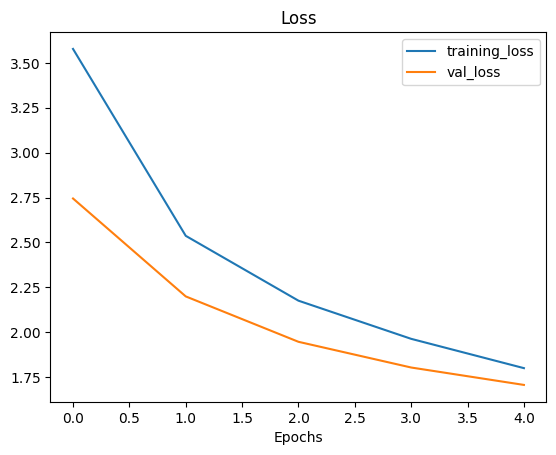

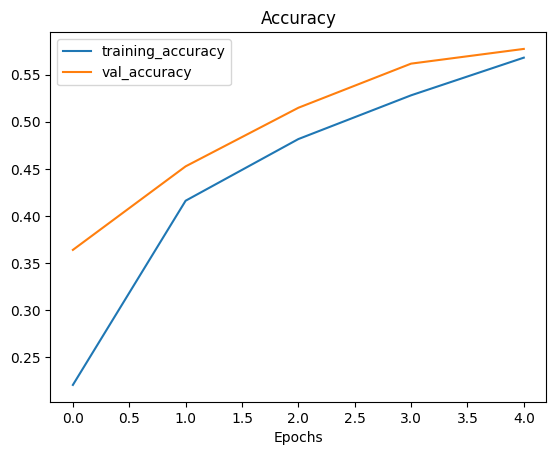

In [ ]:
plot_loss_curves(history_all_classes_10_percent)

## Fine-tuning

In [ ]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
    layer.trainable = False

In [ ]:
# Recompile model with lower learning (it's typically best practice to lower the learning rate when fine-tuning)
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # learning rate lowered by 10x
              metrics=["accuracy"])

In [ ]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [ ]:
# Check which layers are trainable in our base model
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [ ]:
# Fine-tune for 5 more epochs
FINE_TUNE_EPOCHS = 10

# Fine-tune our model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=FINE_TUNE_EPOCHS,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 54s 177ms/step - accuracy: 0.5627 - loss: 1.7727 - val_accuracy: 0.4976 - val_loss: 1.9419
Epoch 6/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 79s 168ms/step - accuracy: 0.6113 - loss: 1.5792 - val_accuracy: 0.5220 - val_loss: 1.8050
Epoch 7/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 40s 165ms/step - accuracy: 0.6346 - loss: 1.4917 - val_accuracy: 0.6006 - val_loss: 1.5478
Epoch 8/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 41s 163ms/step - accuracy: 0.6526 - loss: 1.4050 - val_accuracy: 0.5736 - val_loss: 1.6422
Epoch 9/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 38s 160ms/step - accuracy: 0.6720 - loss: 1.3370 - val_accuracy: 0.6269 - val_loss: 1.4525
Epoch 10/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 40s 158ms/step - accuracy: 0.6776 - loss: 1.3022 - val_accuracy: 0.6041 - val_loss: 1.4474


In [ ]:
# Evaluate on the whole test dataset
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 59s 75ms/step - accuracy: 0.5482 - loss: 1.7146


[1.610543131828308, 0.5720396041870117]

In [ ]:
import matplotlib.pyplot as plt

# Let's create a function to compare training histories
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two TensorFlow History objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history metrics with new_history metrics
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]


    # Make plot for accuracy
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label="Training Accuracy")
    plt.plot(total_val_acc, label="Val Accuracy")
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning", color="r") # Plotting the line where fine tuning started
    plt.legend(loc="lower right")
    plt.title("Training and Validation Accuracy")


    # Make plot for loss
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label="Training Loss")
    plt.plot(total_val_loss, label="Val Loss")
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning", color="r") # Plotting the line where fine tuning started
    plt.legend(loc="upper right")
    plt.title("Training and Validation Loss")

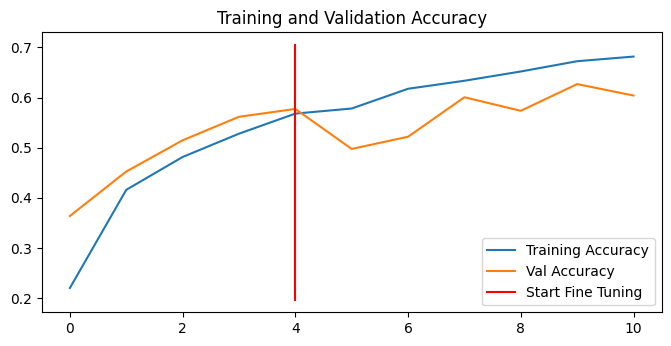

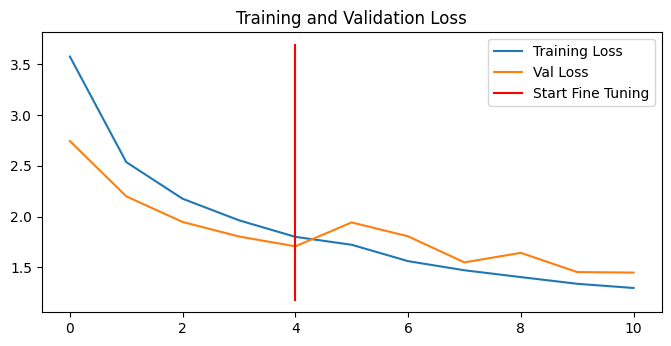

In [ ]:
# Compare the histories of feature extraction model with fine-tuning model
compare_historys(original_history=history_all_classes_10_percent, new_history=history_all_classes_10_percent_fine_tune, initial_epochs=5)

## Saving and loading our model

To use our model in an external application, we'll need to save it and export it somewhere.

In [ ]:
model.save("/content/models/101_food_classes_10_percent_saved_big_dog_model.keras")

In [ ]:
# Load and evaluate save model
loaded_model = tf.keras.models.load_model("/content/models/101_food_classes_10_percent_saved_big_dog_model.keras")

In [ ]:
# Evaluate loaded model and compare performance to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 62s 74ms/step - accuracy: 0.5245 - loss: 1.8264


[1.6867057085037231, 0.5545346736907959]

In [ ]:
# The results from our loaded_model (above) should be very similar to the results below
all_classes_10_percent_fine_tune_results

[1.610543131828308, 0.5720396041870117]

## Making predictions with our trained model

In [ ]:
# Make predictions with model
preds_probs = model.predict(test_data, verbose=1) # Set verbosity to see how long is left

790/790 ━━━━━━━━━━━━━━━━━━━━ 59s 72ms/step


In [ ]:
len(test_data)

790

In [ ]:
# How many predictions are there?
len(preds_probs)

25250

In [ ]:
# What's the shape of our predictions?
preds_probs.shape

(25250, 101)

In [ ]:
# Let's see what the first 10 predictions look like
preds_probs[:10]

array([[3.87746423e-01, 1.42378581e-03, 2.08084941e-01, ...,
        5.62246947e-04, 5.36507973e-03, 4.16960940e-02],
       [9.14058447e-01, 3.79137350e-06, 1.98520720e-03, ...,
        4.31726966e-03, 3.83237557e-06, 9.02669944e-06],
       [2.93001443e-01, 3.97449592e-03, 4.54551028e-03, ...,
        1.81938091e-03, 6.08589267e-04, 7.45939510e-03],
       ...,
       [5.17078936e-01, 1.30269555e-05, 1.08037225e-03, ...,
        5.39960936e-02, 1.79433177e-04, 3.97959549e-04],
       [2.43685186e-01, 1.82271015e-03, 9.96268764e-02, ...,
        4.48169746e-03, 1.98851820e-04, 5.60014800e-04],
       [2.71586061e-01, 2.53664639e-05, 3.79466056e-03, ...,
        2.97711827e-02, 5.12254410e-05, 2.87878048e-03]], dtype=float32)

In [ ]:
# What does the first prediction probability array look like?
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([3.8774642e-01, 1.4237858e-03, 2.0808494e-01, 1.4496411e-06,
        9.0247886e-06, 2.6183692e-05, 1.0958116e-03, 1.5683749e-04,
        3.2639664e-02, 5.6061259e-04, 4.9285729e-05, 3.8692265e-04,
        3.7792986e-03, 7.5667726e-06, 2.9330848e-02, 8.9653581e-04,
        3.9495178e-04, 1.9184847e-03, 4.3177724e-04, 2.0789117e-05,
        3.3927822e-04, 2.8706112e-04, 1.8987621e-03, 6.4737222e-04,
        4.1833302e-04, 4.8899924e-04, 1.2053230e-03, 4.6161083e-05,
        4.0864665e-02, 4.0632528e-03, 2.7533673e-05, 3.3273913e-03,
        3.7670480e-03, 6.1207655e-05, 2.5123138e-02, 1.1187908e-04,
        9.7021833e-04, 3.8683061e-03, 4.5731333e-03, 1.3076456e-04,
        3.2294870e-04, 9.6892379e-04, 1.0719569e-03, 5.4123127e-05,
        1.8980251e-04, 5.4812187e-04, 6.7953422e-04, 2.8972980e-04,
        2.5614983e-05, 4.0727658e-03, 1.3964602e-03, 3.6208523e-05,
        6.8828940e-02, 3.7423144e-03, 5.5351586e-05, 2.0468110e-02,
        2.0104982e-03, 1.9095761e-03, 1.7567828e

Our model outputs a prediction probability array (with N number of variables, where N is the number of classes) for each sample passed to the predict method.

In [ ]:
print(f"Number of prediction probabilities for sample 0: {len(preds_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {preds_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {preds_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [3.8774642e-01 1.4237858e-03 2.0808494e-01 1.4496411e-06 9.0247886e-06
 2.6183692e-05 1.0958116e-03 1.5683749e-04 3.2639664e-02 5.6061259e-04
 4.9285729e-05 3.8692265e-04 3.7792986e-03 7.5667726e-06 2.9330848e-02
 8.9653581e-04 3.9495178e-04 1.9184847e-03 4.3177724e-04 2.0789117e-05
 3.3927822e-04 2.8706112e-04 1.8987621e-03 6.4737222e-04 4.1833302e-04
 4.8899924e-04 1.2053230e-03 4.6161083e-05 4.0864665e-02 4.0632528e-03
 2.7533673e-05 3.3273913e-03 3.7670480e-03 6.1207655e-05 2.5123138e-02
 1.1187908e-04 9.7021833e-04 3.8683061e-03 4.5731333e-03 1.3076456e-04
 3.2294870e-04 9.6892379e-04 1.0719569e-03 5.4123127e-05 1.8980251e-04
 5.4812187e-04 6.7953422e-04 2.8972980e-04 2.5614983e-05 4.0727658e-03
 1.3964602e-03 3.6208523e-05 6.8828940e-02 3.7423144e-03 5.5351586e-05
 2.0468110e-02 2.0104982e-03 1.9095761e-03 1.7567828e-02 6.8157286e-05
 1.6522874e-05 8.4441144e-04 1.2547424e-02 2.

In [ ]:
test_data.class_names[0]

'apple_pie'

In [ ]:
# Get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([ 0,  0,  0, 38,  8, 78, 29,  0,  0,  0])

In [ ]:
# How many pred classes do we have?
len(pred_classes)

25250

Now we've got a predictions array of all of our model's predictions, to evaluate them, we need to compare them to the original test dataset labels.

In [ ]:
# To get our test labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
    y_labels.append(labels.numpy().argmax())
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
# How many y_labels are there?
len(y_labels)

25250

## Evaluating our model's predictions

One way to check that our model's predictions array (pred_classes) is in the same order as our test labels array (y_labels) is to find the accuracy score.

In [ ]:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels, y_pred=pred_classes)
sklearn_accuracy

0.572039603960396

### Let's get visual: making a confusion matrix

In [ ]:
from helper_functions import make_confusion_matrix

In [ ]:
# Get a list of class names
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# We need to make some changes to our make_confusion_matrix function to ensure the x-labels print vertically
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Changed (plot x-labels vertically) ###
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [ ]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      savefig=True)

## Let's keep the evaluation train going, time for a classification report


Scikit-learn has a helpful function for acquiring many different classification metrics per class (e.g. precision, recall and F1) called classification_report, let's try it out.

In [48]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.30      0.17      0.22       250
           1       0.42      0.74      0.54       250
           2       0.59      0.56      0.58       250
           3       0.80      0.52      0.63       250
           4       0.54      0.43      0.48       250
           5       0.40      0.38      0.39       250
           6       0.80      0.67      0.73       250
           7       0.82      0.69      0.75       250
           8       0.27      0.53      0.36       250
           9       0.31      0.62      0.41       250
          10       0.48      0.42      0.45       250
          11       0.77      0.53      0.63       250
          12       0.71      0.56      0.63       250
          13       0.49      0.57      0.52       250
          14       0.47      0.55      0.51       250
          15       0.40      0.33      0.36       250
          16       0.63      0.49      0.55       250
          17       0.35    

In [49]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.3006993006993007,
  'recall': 0.172,
  'f1-score': 0.21882951653944022,
  'support': 250.0},
 '1': {'precision': 0.42045454545454547,
  'recall': 0.74,
  'f1-score': 0.5362318840579711,
  'support': 250.0},
 '2': {'precision': 0.5949367088607594,
  'recall': 0.564,
  'f1-score': 0.5790554414784395,
  'support': 250.0},
 '3': {'precision': 0.7962962962962963,
  'recall': 0.516,
  'f1-score': 0.6262135922330098,
  'support': 250.0},
 '4': {'precision': 0.535,
  'recall': 0.428,
  'f1-score': 0.47555555555555556,
  'support': 250.0},
 '5': {'precision': 0.39748953974895396,
  'recall': 0.38,
  'f1-score': 0.3885480572597137,
  'support': 250.0},
 '6': {'precision': 0.7990430622009569,
  'recall': 0.668,
  'f1-score': 0.7276688453159041,
  'support': 250.0},
 '7': {'precision': 0.8199052132701422,
  'recall': 0.692,
  'f1-score': 0.7505422993492408,
  'support': 250.0},
 '8': {'precision': 0.2697768762677485,
  'recall': 0.532,
  'f1-score': 0.35800807537012114,
  'su

In [50]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report dictionary items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Add class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.21882951653944022,
 'baby_back_ribs': 0.5362318840579711,
 'baklava': 0.5790554414784395,
 'beef_carpaccio': 0.6262135922330098,
 'beef_tartare': 0.47555555555555556,
 'beet_salad': 0.3885480572597137,
 'beignets': 0.7276688453159041,
 'bibimbap': 0.7505422993492408,
 'bread_pudding': 0.35800807537012114,
 'breakfast_burrito': 0.41215323645970936,
 'bruschetta': 0.45010615711252655,
 'caesar_salad': 0.6255924170616114,
 'cannoli': 0.6278026905829597,
 'caprese_salad': 0.5239852398523985,
 'carrot_cake': 0.5054945054945055,
 'ceviche': 0.3648351648351648,
 'cheese_plate': 0.5528089887640449,
 'cheesecake': 0.4006908462867012,
 'chicken_curry': 0.4158790170132325,
 'chicken_quesadilla': 0.5586854460093896,
 'chicken_wings': 0.6953271028037383,
 'chocolate_cake': 0.4782608695652174,
 'chocolate_mousse': 0.3219954648526077,
 'churros': 0.734341252699784,
 'clam_chowder': 0.7094017094017094,
 'club_sandwich': 0.6506986027944112,
 'crab_cakes': 0.3594080338266385,
 'creme_bru

In [51]:
# Trun f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)

In [52]:
# What does our dataframe look like?
f1_scores[:10]

,class_names,f1-score
33,edamame,0.954990
75,pho,0.836134
86,sashimi,0.814672
64,miso_soup,0.806202
69,oysters,0.805785
65,mussels,0.804781
63,macarons,0.803738
32,dumplings,0.802281
45,frozen_yogurt,0.800000
54,hot_and_sour_soup,0.789474


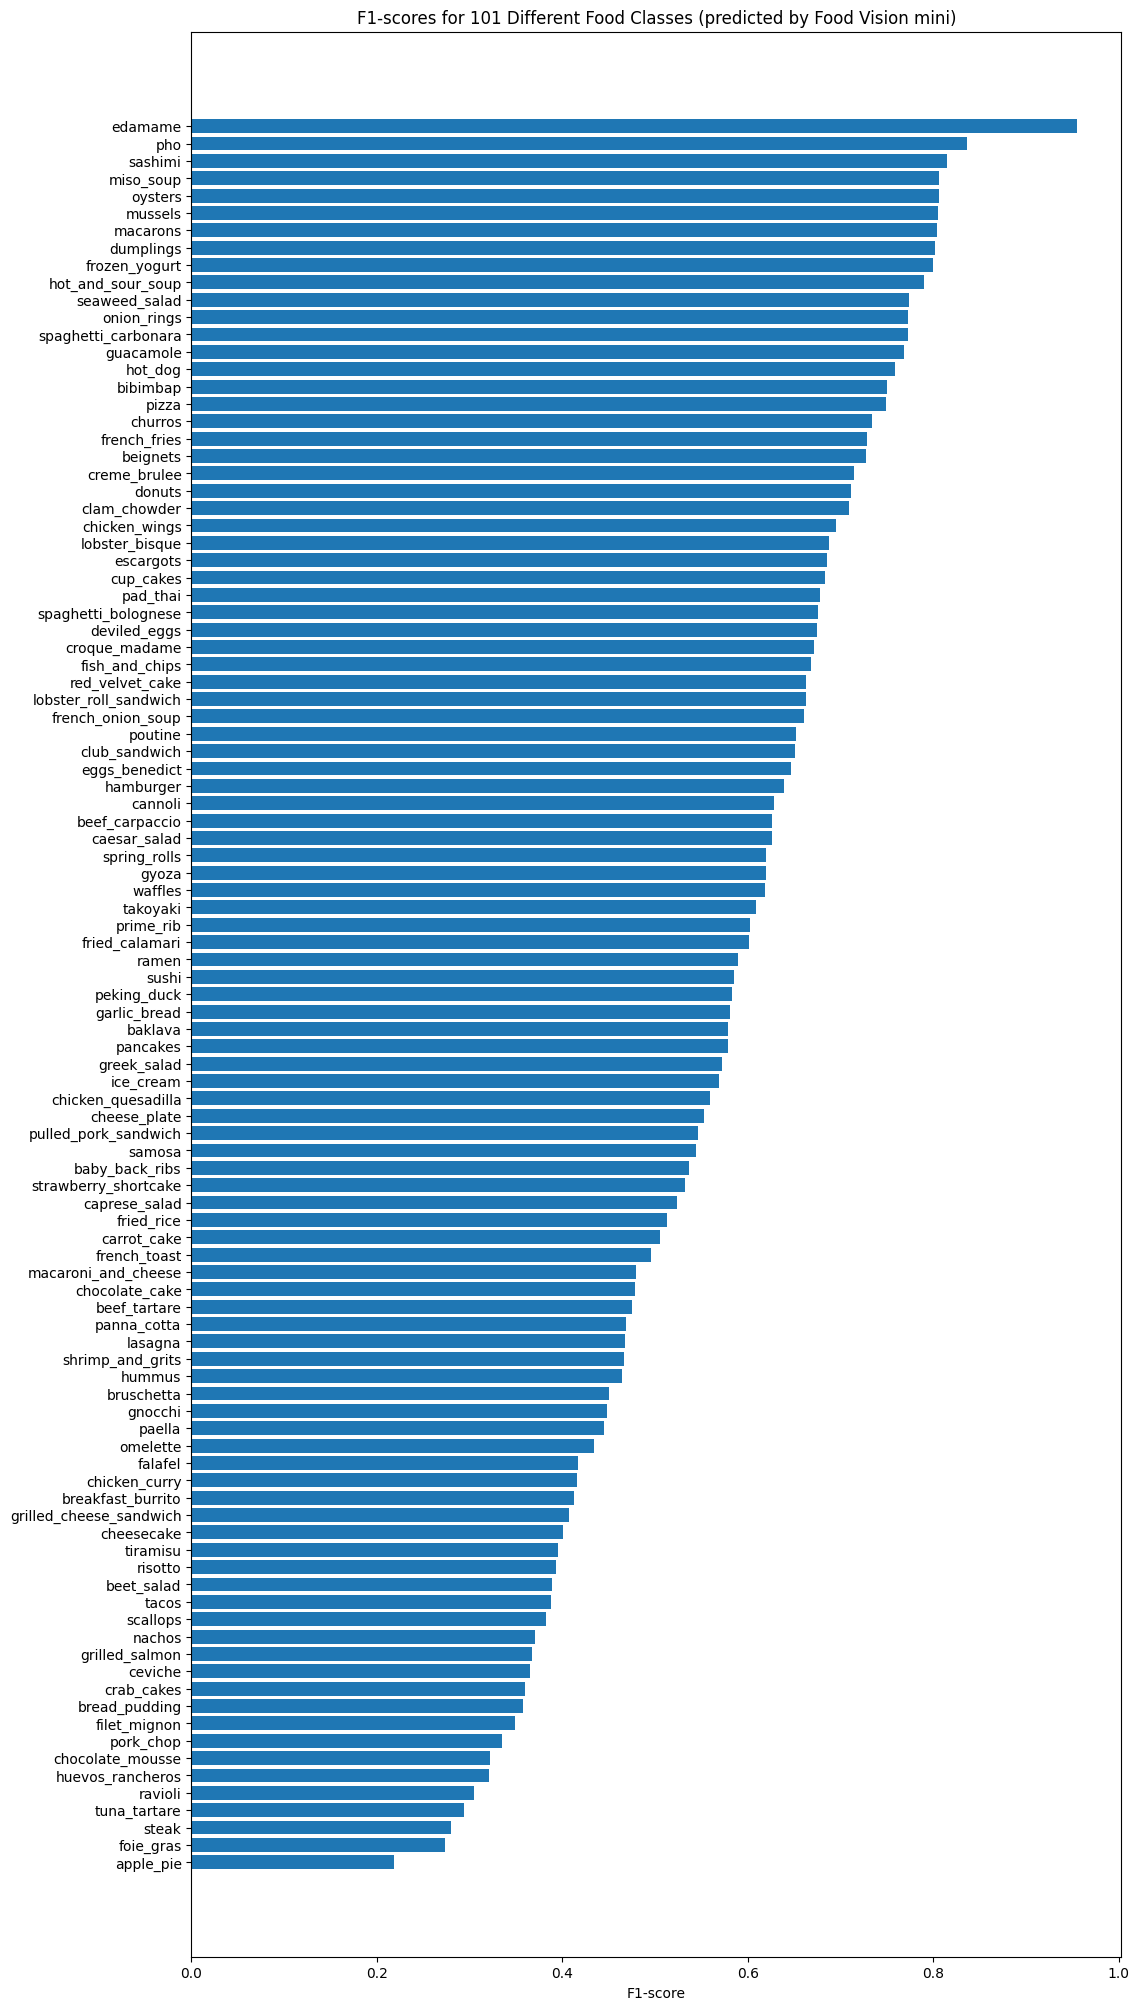

In [55]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values) # get f1-score values
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1-scores for 101 Different Food Classes (predicted by Food Vision mini)")
ax.invert_yaxis(); # reverse the order of our plot